In [10]:
import numpy 
import pandas
import cobra
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
from cobra import Model, Reaction, Metabolite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cobra.flux_analysis import pfba

## 1. Generate fluxes for 100 points on an Ecoli.core Model with decreasing oxygen

In [2]:
model = load_model('textbook')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
model

Name,e_coli_core
Memory address,0x07f7da8cc7d30
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [5]:
solution = model.optimize()
solution.objective_value

0.8739215069684304

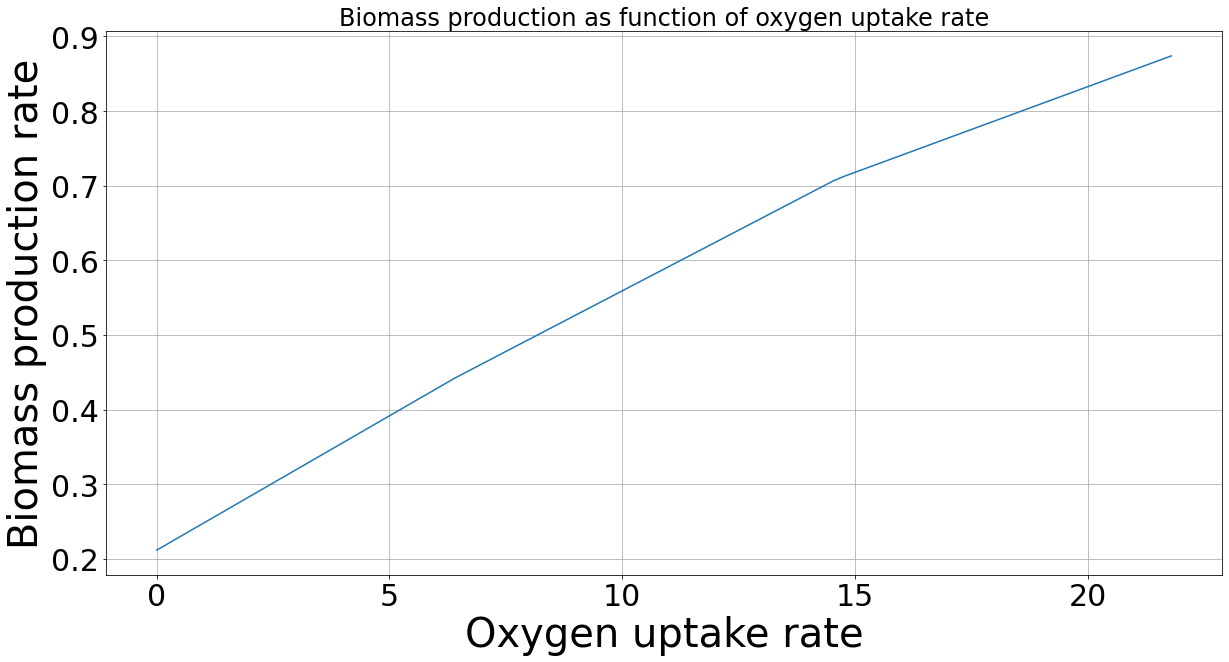

In [6]:
# higher_boundary
# model is exploring 21.8 units of o2
# Explore 100 points from 0 to 21.8 
# Then see impact of biomass
# x see impact of biomass
# do FBA and "pFBA"
# 
oxygen_fluxes = numpy.linspace(0, 21.8, 100)  

resulting_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux  # NOTE: the negative sign, uptake reactions are typically negative in cobra models
    solution = model.optimize()
    if solution.status == 'optimal':
        resulting_fluxes.append(solution.objective_value)
    else:
        resulting_fluxes.append(numpy.nan)

matplotlib.pyplot.figure(figsize = (20, 10))
matplotlib.pyplot.plot(oxygen_fluxes, resulting_fluxes)
matplotlib.pyplot.xlabel('Oxygen uptake rate')
matplotlib.pyplot.ylabel('Biomass production rate')
matplotlib.pyplot.title('Biomass production as function of oxygen uptake rate')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()


In [7]:
oxygen_fluxes

array([ 0.        ,  0.22020202,  0.44040404,  0.66060606,  0.88080808,
        1.1010101 ,  1.32121212,  1.54141414,  1.76161616,  1.98181818,
        2.2020202 ,  2.42222222,  2.64242424,  2.86262626,  3.08282828,
        3.3030303 ,  3.52323232,  3.74343434,  3.96363636,  4.18383838,
        4.4040404 ,  4.62424242,  4.84444444,  5.06464646,  5.28484848,
        5.50505051,  5.72525253,  5.94545455,  6.16565657,  6.38585859,
        6.60606061,  6.82626263,  7.04646465,  7.26666667,  7.48686869,
        7.70707071,  7.92727273,  8.14747475,  8.36767677,  8.58787879,
        8.80808081,  9.02828283,  9.24848485,  9.46868687,  9.68888889,
        9.90909091, 10.12929293, 10.34949495, 10.56969697, 10.78989899,
       11.01010101, 11.23030303, 11.45050505, 11.67070707, 11.89090909,
       12.11111111, 12.33131313, 12.55151515, 12.77171717, 12.99191919,
       13.21212121, 13.43232323, 13.65252525, 13.87272727, 14.09292929,
       14.31313131, 14.53333333, 14.75353535, 14.97373737, 15.19

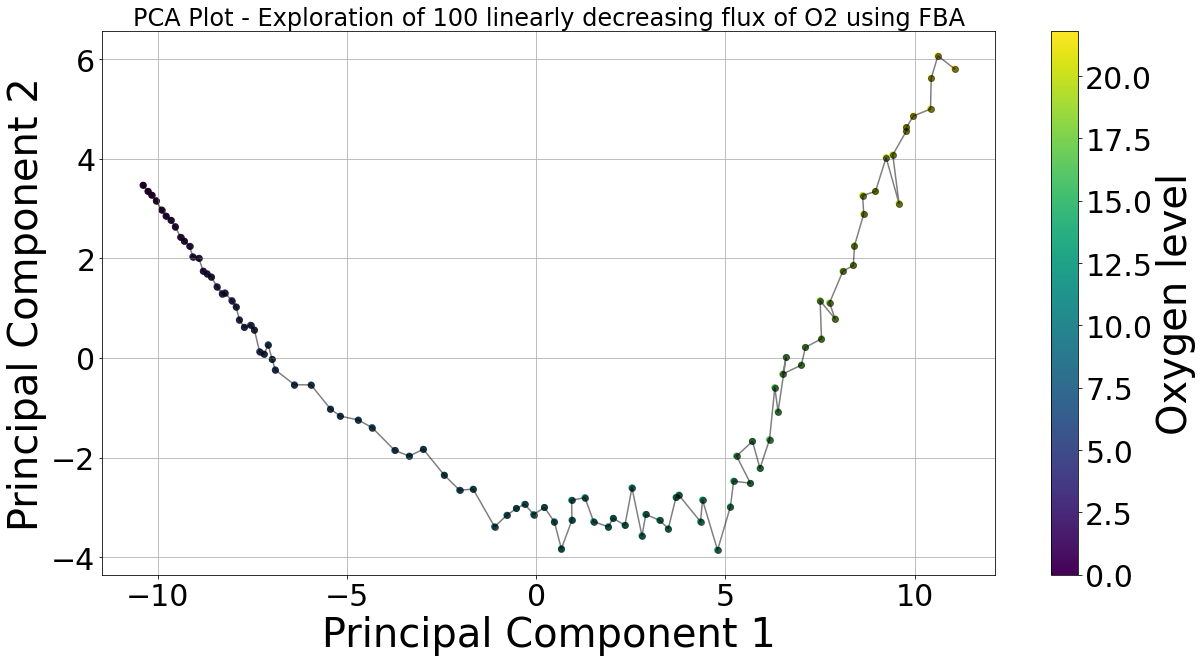

In [12]:
all_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = model.optimize()
    if solution.status == 'optimal':
        all_fluxes.append(solution.fluxes)
    else:
        all_fluxes.append([numpy.nan]*len(model.reactions))

df = pandas.DataFrame(all_fluxes, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes, cmap = 'viridis')  # using oxygen_fluxes for color

ax.plot(principalDf['principal component 1'], principalDf['principal component 2'], '-o', color='black', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using FBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen level')
ax.grid(True)
matplotlib.pyplot.show()

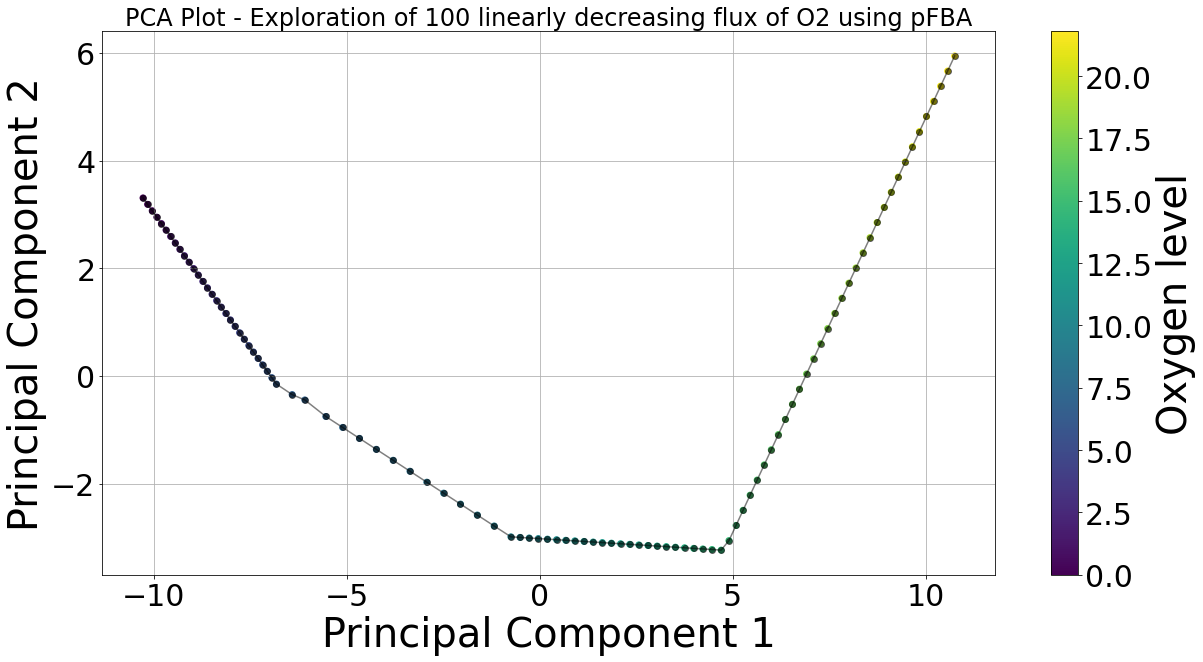

In [13]:
all_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = pfba(model)  # pFBA
    if solution:
        all_fluxes.append(solution.fluxes)
    else:
        all_fluxes.append([numpy.nan]*len(model.reactions))

df = pandas.DataFrame(all_fluxes, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes, cmap = 'viridis')  # using oxygen_fluxes for color

ax.plot(principalDf['principal component 1'], principalDf['principal component 2'], '-o', color='black', alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using pFBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen level')
ax.grid(True)
matplotlib.pyplot.show()